In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/talkingdata-adtracking-fraud-detection/train_sample.csv
/kaggle/input/talkingdata-adtracking-fraud-detection/sample_submission.csv
/kaggle/input/talkingdata-adtracking-fraud-detection/test.csv
/kaggle/input/talkingdata-adtracking-fraud-detection/test_supplement.csv
/kaggle/input/talkingdata-adtracking-fraud-detection/train.csv


In [3]:
import subprocess
print('# Line count:')
for file in ['train.csv', 'test.csv', 'train_sample.csv']:
    lines = subprocess.run(['wc', '-l', '/kaggle/input/talkingdata-adtracking-fraud-detection/{}'.format(file)], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(lines, end='', flush=True)

# Line count:
184903891 /kaggle/input/talkingdata-adtracking-fraud-detection/train.csv
18790470 /kaggle/input/talkingdata-adtracking-fraud-detection/test.csv
100001 /kaggle/input/talkingdata-adtracking-fraud-detection/train_sample.csv


In [4]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pal = sns.color_palette()

In [5]:
path = '/kaggle/input/talkingdata-adtracking-fraud-detection/'

In [6]:
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }

In [7]:
train_sample_df = pd.read_csv(path+"train_sample.csv", dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'], parse_dates=['click_time'])

In [8]:
train_sample_df.head()

,ip,app,device,os,channel,click_time,is_attributed
0,29540,3,1,42,489,2017-11-08 03:57:46,0
1,26777,11,1,25,319,2017-11-09 11:02:14,0
2,140926,12,1,13,140,2017-11-07 04:36:14,0
3,69375,2,1,19,377,2017-11-09 13:17:20,0
4,119166,9,2,15,445,2017-11-07 12:11:37,0


In [9]:
train_sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
ip               100000 non-null uint32
app              100000 non-null uint16
device           100000 non-null uint16
os               100000 non-null uint16
channel          100000 non-null uint16
click_time       100000 non-null datetime64[ns]
is_attributed    100000 non-null uint8
dtypes: datetime64[ns](1), uint16(4), uint32(1), uint8(1)
memory usage: 2.0 MB


In [10]:
train_sample_df.describe()

,ip,app,device,os,channel,is_attributed
count,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,91091.47618,12.033790,22.390540,22.835020,268.656180,0.002510
std,69791.74842,14.917195,264.110407,56.829508,129.692927,0.050037
min,9.00000,0.000000,0.000000,0.000000,3.000000,0.000000
25%,40315.50000,3.000000,1.000000,13.000000,140.000000,0.000000
50%,79666.00000,12.000000,1.000000,18.000000,258.000000,0.000000
75%,118284.00000,15.000000,1.000000,19.000000,379.000000,0.000000
max,364759.00000,542.000000,3866.000000,866.000000,498.000000,1.000000


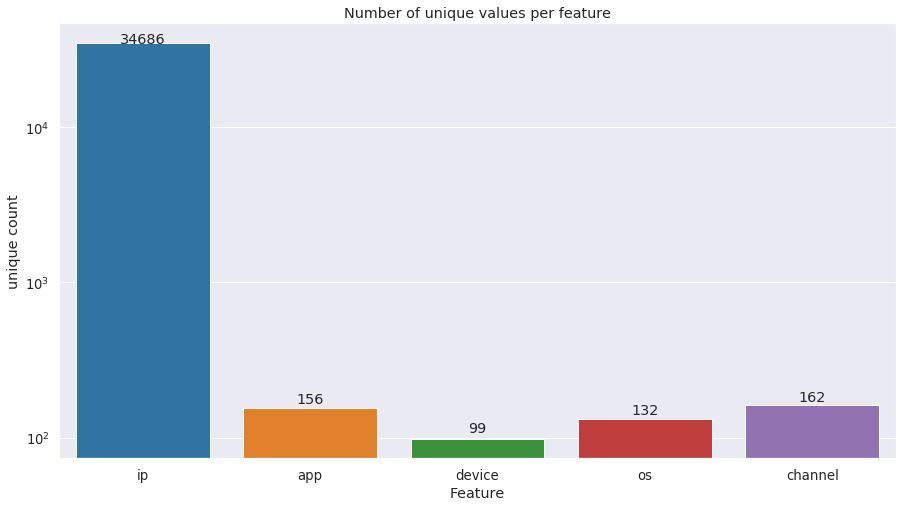

In [11]:
plt.figure(figsize=(15, 8))
cols = ['ip', 'app', 'device', 'os', 'channel']
uniques = [len(train_sample_df[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, palette=pal, log=True)
ax.set(xlabel='Feature', ylabel='unique count', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center")

[Text(0, 0.5, 'Count of users'),
 Text(0.5, 1.0, 'Count of users with App Downloaded vs Not Downloaded')]

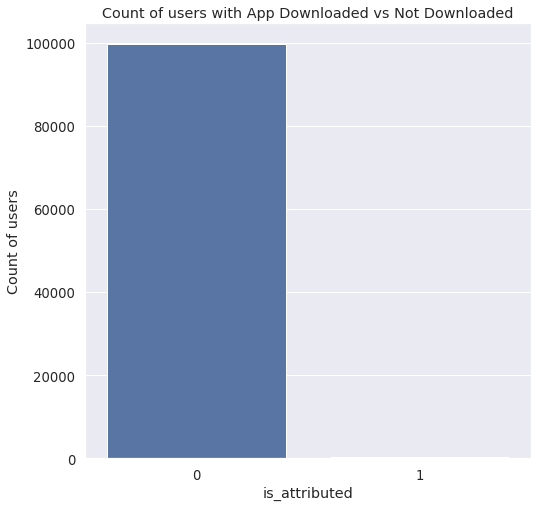

In [12]:
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.2)
ax=sns.countplot(train_sample_df['is_attributed']);
ax.set(ylabel='Count of users', title='Count of users with App Downloaded vs Not Downloaded')

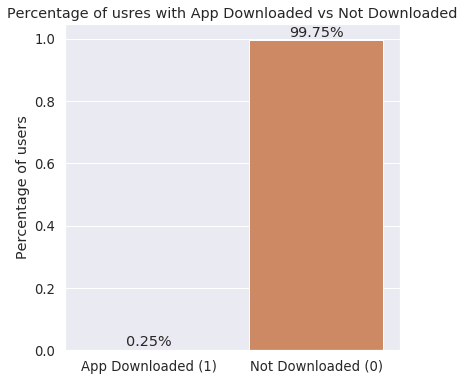

In [13]:
plt.figure(figsize=(6,6))
#sns.set(font_scale=1.2)
mean = (train_sample_df.is_attributed.values == 1).mean()
ax = sns.barplot(['App Downloaded (1)', 'Not Downloaded (0)'], [mean, 1-mean])
ax.set(ylabel='Percentage of users', title='Percentage of usres with App Downloaded vs Not Downloaded')
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center")

In [14]:
categorical = ['ip', 'app', 'device', 'os', 'channel']
for v in categorical:
    train_sample_df[v] = train_sample_df[v].astype('category')

Check if the IP's have too many clicks and do those IP's convert

In [15]:
#table to see ips with their associated total clicks
ip_repeat_df = train_sample_df['ip'].value_counts().reset_index(name='count_clicks')
ip_repeat_df.columns = ['ip', 'count_clicks']
ip_repeat_df[:10]

,ip,count_clicks
0,5348,687
1,5314,640
2,73487,436
3,73516,423
4,53454,249
5,114276,242
6,26995,231
7,95766,202
8,100275,162
9,17149,162


In [16]:
train_sample_df= train_sample_df.merge(ip_repeat_df, on='ip', how='left')
train_sample_df[train_sample_df['is_attributed']==1].sort_values('count_clicks', ascending=False)[:10]

,ip,app,device,os,channel,click_time,is_attributed,count_clicks
44349,5314,20,1,27,478,2017-11-08 06:42:28,1,640
7946,5314,19,0,0,347,2017-11-09 08:11:01,1,640
96346,5314,19,88,24,213,2017-11-07 22:25:07,1,640
93796,100275,29,1,15,213,2017-11-07 13:10:17,1,162
59781,100275,9,1,19,258,2017-11-08 10:38:30,1,162
56251,123994,9,1,19,244,2017-11-08 18:55:18,1,90
55450,175837,19,6,29,213,2017-11-08 04:50:46,1,63
50861,100971,29,1,13,213,2017-11-07 03:01:41,1,48
33847,118252,19,353,76,347,2017-11-08 11:27:56,1,42
90422,75007,29,1,19,343,2017-11-08 10:34:41,1,34


In [17]:
train_sample_df[train_sample_df['is_attributed']==1].ip.describe()

count      251
unique     248
top       5314
freq         3
Name: ip, dtype: int64

That means IP's with higher number of clicks do install the app and it is not realted to any click spam. However, this anlysis is just based on the sample traiing data which is merely 100,000 records.

Verify the time trends of the clicks and installs

In [18]:
train_sample_df['click_hour']=train_sample_df['click_time'].dt.hour
train_sample_df.head()

,ip,app,device,os,channel,click_time,is_attributed,count_clicks,click_hour
0,29540,3,1,42,489,2017-11-08 03:57:46,0,3,3
1,26777,11,1,25,319,2017-11-09 11:02:14,0,5,11
2,140926,12,1,13,140,2017-11-07 04:36:14,0,1,4
3,69375,2,1,19,377,2017-11-09 13:17:20,0,35,13
4,119166,9,2,15,445,2017-11-07 12:11:37,0,2,12


Click and conversion trends based on the click hour of the day

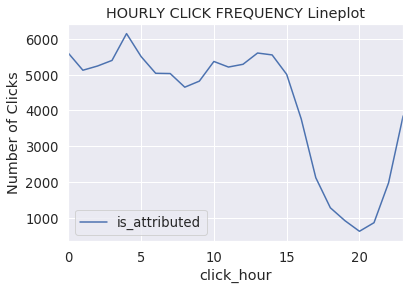

In [19]:
train_sample_df[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot()
plt.title('HOURLY CLICK FREQUENCY Lineplot');
plt.ylabel('Number of Clicks');

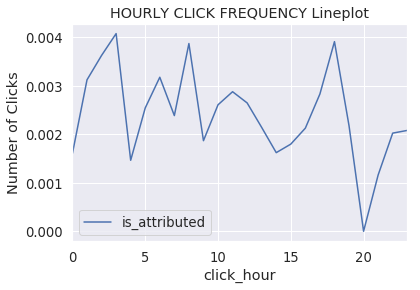

In [20]:
train_sample_df[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).mean().plot()
plt.title('HOURLY CLICK FREQUENCY Lineplot');
plt.ylabel('Number of Clicks');

The trend of click to conversion with hour of the day does not show any clear patterns because during the hours between 15-19, clciks were minimum whereas the conversions were maximum. On the contrarat during the 20th hour, clicks and the corresponding conversions were almost negligible as compared to rets of the day. 
I will look at the actual training data to make some conclusions for the hourly trend and using it a s afeature to train the model

Text(0, 0.5, 'Number of Clicks')

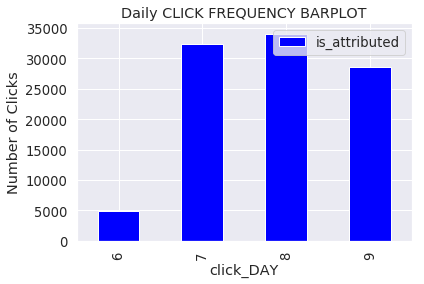

In [43]:
train_sample_df['click_DAY']=train_sample_df['click_time'].dt.day
train_sample_df[['click_DAY','is_attributed']].groupby(['click_DAY'], as_index=True).count().plot(kind='bar', color='blue')
plt.title('Daily CLICK FREQUENCY BARPLOT');
plt.ylabel('Number of Clicks')

In [21]:
train_df = pd.read_csv(path+"train.csv",  nrows=30000000, dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'])

In [22]:
test_df = pd.read_csv(path+"test.csv", dtype=dtypes,skiprows=range(1,11290470), nrows=7500000, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])

In [23]:
print(train_df.head())
print(test_df.head())

       ip  app  device  os  channel           click_time  is_attributed
0   83230    3       1  13      379  2017-11-06 14:32:21              0
1   17357    3       1  19      379  2017-11-06 14:33:34              0
2   35810    3       1  13      379  2017-11-06 14:34:12              0
3   45745   14       1  13      478  2017-11-06 14:34:52              0
4  161007    3       1  13      379  2017-11-06 14:35:08              0
   click_id      ip  app  device  os  channel           click_time
0  11290469   91154   17       1  19      128  2017-11-10 10:40:24
1  11290470   77391   21       1  19      232  2017-11-10 10:40:24
2  11290471  125592   10       1   6      377  2017-11-10 10:40:24
3  11290472   50924    9       1  19      215  2017-11-10 10:40:24
4  11290473   92919    9       1   9      127  2017-11-10 10:40:24


In [24]:
variables = ['ip', 'app', 'device', 'os', 'channel']
for v in variables:
    train_df[v] = train_df[v].astype('category')
    test_df[v]=test_df[v].astype('category')

In [25]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000000 entries, 0 to 29999999
Data columns (total 7 columns):
ip               category
app              category
device           category
os               category
channel          category
click_time       object
is_attributed    uint8
dtypes: category(5), object(1), uint8(1)
memory usage: 604.1+ MB


In [26]:
train_df['click_time'] = pd.to_datetime(train_df['click_time'])
test_df['click_time'] = pd.to_datetime(test_df['click_time'])

In [27]:
train_df['click_hour']=train_df['click_time'].dt.hour
test_df['click_hour']=test_df['click_time'].dt.hour

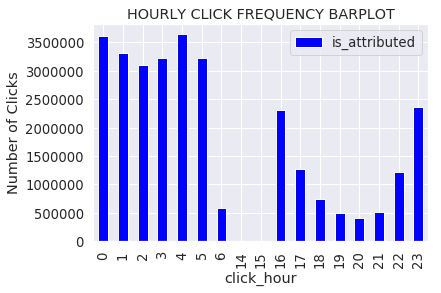

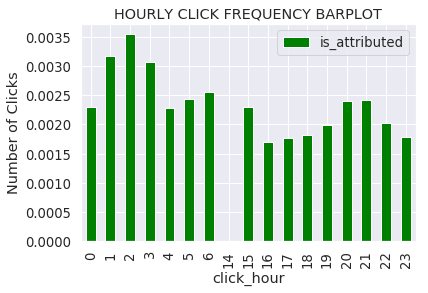

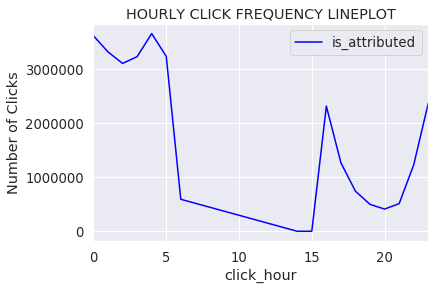

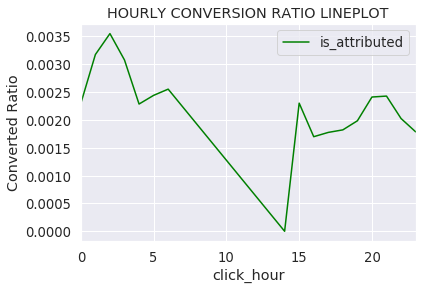

In [28]:
#check for hourly patterns of training data
train_df[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot(kind='bar', color='blue')
plt.title('HOURLY CLICK FREQUENCY BARPLOT');
plt.ylabel('Number of Clicks')

train_df[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).mean().plot(kind='bar', color='green')
plt.title('HOURLY CLICK FREQUENCY BARPLOT');
plt.ylabel('Number of Clicks')

train_df[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot(color='blue')
plt.title('HOURLY CLICK FREQUENCY LINEPLOT');
plt.ylabel('Number of Clicks');

train_df[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).mean().plot(color='green')
plt.title('HOURLY CONVERSION RATIO LINEPLOT');
plt.ylabel('Converted Ratio');

In [29]:
train_df['click_DAY']=train_df['click_time'].dt.day

Text(0, 0.5, 'Number of Clicks')

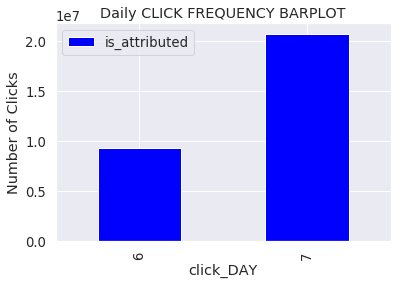

In [30]:
train_df[['click_DAY','is_attributed']].groupby(['click_DAY'], as_index=True).count().plot(kind='bar', color='blue')
plt.title('Daily CLICK FREQUENCY BARPLOT');
plt.ylabel('Number of Clicks')

The above plot shows that the training data that I have chosen have clicks from two days and all hours of the day does not have data. I am not considering day as the feature. Other thing I can try is to take the hour information because early hours of the morning from 1-3 shows maximum clicks which is a bit odd. 

Generating new features from IP, app, OS,Device, Channel utilizing the click_hour data alongwith.
First of all, I will combine both training and test data so that all the features can be derived simultaneously for both training and test set.

In [31]:
train_samples = len(train_df)
train_df=train_df.append(test_df)

1. Getting the count of clicks for ip-hour combination
2. Getting the count of clicks for ip-app combination
3. Getting the count of clicks for ip-app-os combination
4. Getting the count of clicks for ip-device-os combination


In [32]:
import gc

In [33]:
del test_df
gc.collect()

12056

In [34]:
temp_df = train_df[['ip','click_hour','channel']].groupby(by=['ip','click_hour'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_hour_count'})
train_df = train_df.merge(temp_df, on=['ip','click_hour'], how='left')
del temp_df
gc.collect()
train_df.head()

,app,channel,click_DAY,click_hour,click_id,click_time,device,ip,is_attributed,os,ip_hour_count
0,3,379,6.0,14,NaN,2017-11-06 14:32:21,1,83230,0.0,13,232
1,3,379,6.0,14,NaN,2017-11-06 14:33:34,1,17357,0.0,19,256
2,3,379,6.0,14,NaN,2017-11-06 14:34:12,1,35810,0.0,13,280
3,14,478,6.0,14,NaN,2017-11-06 14:34:52,1,45745,0.0,13,4398
4,3,379,6.0,14,NaN,2017-11-06 14:35:08,1,161007,0.0,13,1


In [35]:
temp_df = train_df[['ip', 'app', 'channel']].groupby(by=['ip', 'app'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_count'})
train_df = train_df.merge(temp_df, on=['ip','app'], how='left')
del temp_df
gc.collect()
train_df.head()

,app,channel,click_DAY,click_hour,click_id,click_time,device,ip,is_attributed,os,ip_hour_count,ip_app_count
0,3,379,6.0,14,NaN,2017-11-06 14:32:21,1,83230,0.0,13,232,1081
1,3,379,6.0,14,NaN,2017-11-06 14:33:34,1,17357,0.0,19,256,840
2,3,379,6.0,14,NaN,2017-11-06 14:34:12,1,35810,0.0,13,280,292
3,14,478,6.0,14,NaN,2017-11-06 14:34:52,1,45745,0.0,13,4398,2075
4,3,379,6.0,14,NaN,2017-11-06 14:35:08,1,161007,0.0,13,1,95


In [36]:
temp_df = train_df[['ip', 'app','os', 'channel']].groupby(by=['ip', 'app','os'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_app_os_count'})
train_df = train_df.merge(temp_df, on=['ip','app','os'], how='left')
del temp_df
gc.collect()
train_df.head()

,app,channel,click_DAY,click_hour,click_id,click_time,device,ip,is_attributed,os,ip_hour_count,ip_app_count,ip_app_os_count
0,3,379,6.0,14,NaN,2017-11-06 14:32:21,1,83230,0.0,13,232,1081,294
1,3,379,6.0,14,NaN,2017-11-06 14:33:34,1,17357,0.0,19,256,840,227
2,3,379,6.0,14,NaN,2017-11-06 14:34:12,1,35810,0.0,13,280,292,69
3,14,478,6.0,14,NaN,2017-11-06 14:34:52,1,45745,0.0,13,4398,2075,458
4,3,379,6.0,14,NaN,2017-11-06 14:35:08,1,161007,0.0,13,1,95,32


In [38]:
temp_df = train_df[['ip', 'device','os', 'channel']].groupby(by=['ip', 'device','os'])[['channel']].count().reset_index().rename(index=str, columns={'channel': 'ip_device_os_count'})
train_df = train_df.merge(temp_df, on=['ip','device','os'], how='left')
del temp_df
gc.collect()
train_df.head()

,app,channel,click_DAY,click_hour,click_id,click_time,device,ip,is_attributed,os,ip_hour_count,ip_app_count,ip_app_os_count,ip_device_os_count
0,3,379,6.0,14,NaN,2017-11-06 14:32:21,1,83230,0.0,13,232,1081,294,1741
1,3,379,6.0,14,NaN,2017-11-06 14:33:34,1,17357,0.0,19,256,840,227,1071
2,3,379,6.0,14,NaN,2017-11-06 14:34:12,1,35810,0.0,13,280,292,69,327
3,14,478,6.0,14,NaN,2017-11-06 14:34:52,1,45745,0.0,13,4398,2075,458,6717
4,3,379,6.0,14,NaN,2017-11-06 14:35:08,1,161007,0.0,13,1,95,32,108


In [45]:
import lightgbm as lgb

def lgb_modelfit(params, dtrain, dvalid, predictors, target='target', objective='binary', metrics='auc',
                 feval=None, early_stopping_rounds=20, num_boost_round=3000, verbose_eval=10, categorical_features=None):
    lgb_params = {
        'boosting_type': 'gbdt',
        'objective': objective,
        'metric':metrics,
        'learning_rate': 0.01,
        'num_leaves': 31,  
        'max_depth': -1,  # -1 means no limit
        'min_child_samples': 20,  
        'max_bin': 255,  
        'subsample': 0.6,  
        'subsample_freq': 0, 
        'colsample_bytree': 0.3,  
        'min_child_weight': 5,  
        'subsample_for_bin': 200000,  
        'min_split_gain': 0,  
        'reg_alpha': 0,  
        'reg_lambda': 0,  
        'nthread': 4,
        'verbose': 0,
        'metric':metrics
    }

    lgb_params.update(params)

    print("preparing validation datasets")

    xgtrain = lgb.Dataset(dtrain[predictors].values, label=dtrain[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )
    xgvalid = lgb.Dataset(dvalid[predictors].values, label=dvalid[target].values,
                          feature_name=predictors,
                          categorical_feature=categorical_features
                          )

    evals_results = {}

    bst1 = lgb.train(lgb_params, 
                     xgtrain, 
                     valid_sets=[xgtrain, xgvalid], 
                     valid_names=['train','valid'], 
                     evals_result=evals_results, 
                     num_boost_round=num_boost_round,
                     early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=10, 
                     feval=feval)

    n_estimators = bst1.best_iteration
    print("\nModel Report")
    print("n_estimators : ", n_estimators)
    print(metrics+":", evals_results['valid'][metrics][n_estimators-1])

    return bst1

In [40]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37500000 entries, 0 to 37499999
Data columns (total 14 columns):
app                   uint64
channel               uint64
click_DAY             float64
click_hour            int64
click_id              float64
click_time            datetime64[ns]
device                uint64
ip                    uint64
is_attributed         float64
os                    uint64
ip_hour_count         int64
ip_app_count          int64
ip_app_os_count       int64
ip_device_os_count    int64
dtypes: datetime64[ns](1), float64(3), int64(5), uint64(5)
memory usage: 4.2 GB


In [42]:
test_df = train_df[train_samples:]
val_df = train_df[(train_samples-3000000):train_samples]
train_df = train_df[:(train_samples-3000000)]

print("train size: ", len(train_df))
print("valid size: ", len(val_df))
print("test size : ", len(test_df))

train size:  27000000
valid size:  3000000
test size :  7500000


In [49]:
# removed IP from features as the ip has been mainly used to extract new features. 
target = 'is_attributed'
predictors = ['app','device','os', 'channel', 'click_hour',  
              'ip_hour_count', 'ip_app_count', 'ip_app_os_count','ip_device_os_count' ]
categorical = ['app', 'device', 'os', 'channel', 'click_hour']

test_reference = pd.DataFrame()
test_reference['click_id'] = test_df['click_id'].astype('int')


In [50]:
import time
print("Training...")
start_time = time.time()


params = {
    'learning_rate': 0.15,
    'num_leaves': 7,  
    'max_depth': 3, 
    'min_child_samples': 100,  
    'max_bin': 100, 
    'subsample': 0.7,  
    'subsample_freq': 1,  
    'colsample_bytree': 0.9, 
    'min_child_weight': 0,  
    'scale_pos_weight':99 # because training data is extremely unbalanced 
}
bst = lgb_modelfit(params, 
                        train_df, 
                        val_df, 
                        predictors, 
                        target, 
                        objective='binary', 
                        metrics='auc',
                        early_stopping_rounds=30, 
                        verbose_eval=True, 
                        num_boost_round=500, 
                        categorical_features=categorical)

print('[{}]: model training time'.format(time.time() - start_time))

Training...
preparing validation datasets
Training until validation scores don't improve for 30 rounds.
[10]	train's auc: 0.948351	valid's auc: 0.941501
[20]	train's auc: 0.955408	valid's auc: 0.946767
[30]	train's auc: 0.949315	valid's auc: 0.939071
[40]	train's auc: 0.956295	valid's auc: 0.947097
[50]	train's auc: 0.957441	valid's auc: 0.947323
Early stopping, best iteration is:
[27]	train's auc: 0.957111	valid's auc: 0.949425

Model Report
n_estimators :  27
auc: 0.9494251674999896
[352.81622552871704]: model training time


In [53]:
print("Calculating predictions")
test_reference['is_attributed'] = bst.predict(test_df[predictors])
print("writing the results to test_predictions.csv")
test_reference.to_csv('test_predictions.csv',index=False)
print("Predictions calculated and written into csv file")

Calculating predictions
writing the results to test_predictions.csv
Predictions calculated and written into csv file


In [57]:
test_reference.tail()

,click_id,is_attributed
37499995,18790464,0.784562
37499996,18790465,0.004350
37499997,18790467,0.018101
37499998,18790466,0.781808
37499999,18790468,0.014060


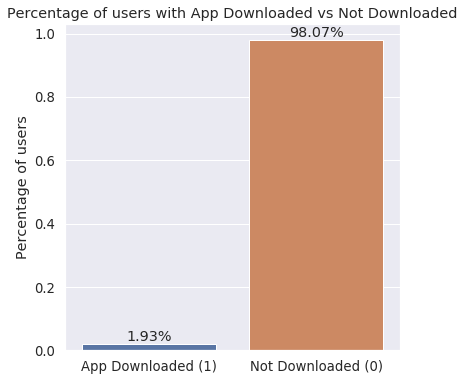

In [59]:
plt.figure(figsize=(6,6))
#sns.set(font_scale=1.2)
mean = (test_reference.is_attributed.values == 1).mean()
ax = sns.barplot(['App Downloaded (1)', 'Not Downloaded (0)'], [mean, 1-mean])
ax.set(ylabel='Percentage of users', title='Percentage of users with App Downloaded vs Not Downloaded')
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center")

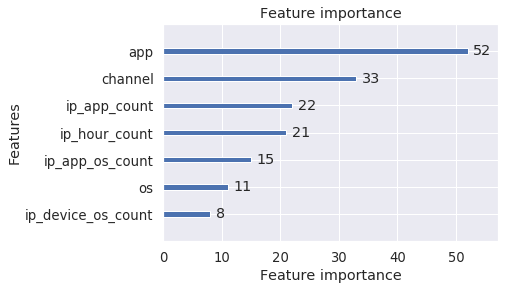

In [60]:
lgb.plot_importance(bst, importance_type='split')
